<h1 align="center"> HR Data for Analytics </h1>

## Project Goal

Analyze the HR dataset, find factors that lead to employee attrition, and build models to predict the attrition.

## About Dataset
This dataset is from Kaggle, the link is [here](https://www.kaggle.com/datasets/jacksonchou/hr-data-for-analytics?datasetId=236694&sortBy=voteCount).
The dataset contains employee profiles of a large company, where each record is an employee.

Attributes in the dataset are:
- ***`satisfaction_level`*** : how much an employee satisfied (0 ~ 1, 0 unsatisfied, 1 satisfied)  
- ***`last_evaluation`*** : an employee's value evaluated by company (0 ~ 1, 0 low , 1 high)
- ***`number_project`*** : number of projects an employee worked on
- ***`average_montly_hours`*** : an employee's average working hours per month
- ***`time_spend_company`*** : years an employee spent in the company
- ***`Work_accident`*** : if an employee had at least one work accident (0 No, 1 Yes)
- ***`left`*** : if an employee left the company (0 No, 1 Yes)
- ***`promotion_last_5years`*** : if an employee had at least one promotion for last five years (0 No, 1 Yes)
- ***`sales`*** : department in which employee works
- ***`salary`*** : an employee's salary level (low, medium, high)

***
<h1 align="center"> Data Cleaning </h1>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set seaborn theme
sns.set_theme(style='white', palette='bright')

In [6]:
def adjust_boxplot():
    '''
    Adjust the boxplot
    '''
    plt.box(False)
    plt.gca().yaxis.label.set_size(20)
    plt.gca().yaxis.labelpad = 0
    plt.tick_params(bottom=False, left=False, labelsize=13, pad=-55)
    plt.tight_layout()
    

def adjust_legend(fig):
    '''
    Adjust legend's position
    '''
    legend = fig.get_legend()
    #legend.get_frame().set_linewidth(0)  
    legend.set_frame_on(False)
    plt.rcParams['legend.loc'] = 'center left'
    legend.set_bbox_to_anchor((0.71, 0.95))    
    legend.set_title('')
    legend.texts[0].set_text('stay')
    legend.texts[1].set_text('left')
    

def show_count_percentage(fig): 
    """
    Show the attrition rate(left=0 and left=1) in the middle of the bar
    """
    
    cat_group = int(len(fig.patches)/2)
    for i in range(cat_group):        
        stayed = fig.patches[i]
        left = fig.patches[i+cat_group]
        total = stayed.get_height() + left.get_height()
        
        for bar in [stayed, left]:
            percentage = '{:.1f}%'.format(bar.get_height() / total * 100)
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height() * 0.45
            fig.annotate(percentage, (x, y), ha='center', color='black', size=15)    
    
    
def adjust_barplot(fig, title='', rotate=0):    
    """
    Show the attrition rate(left=0 and left=1) in the middle of the bar, show the count on top of the bar, and different ticklabels 
    """
    
    # adjust the figure
    fig.set_title(title, size=20, pad=40)
    variable = fig.get_xlabel()
    fig.set_xlabel('')
    fig.set_ylabel('Employee Count', size=15, labelpad=5)        
    fig.set_frame_on(False)
    fig.tick_params(labelleft=False, left=False, bottom=False, labelsize=15, labelrotation=rotate)
    
    # show the different x ticklabels and total counts on top of the bar
    # for hue='left'
    try:
        # show total counts on top of the bar and adjust the legend
        fig.bar_label(fig.containers[1], padding=10, size=14)
        fig.bar_label(fig.containers[0], padding=10, size=14)    
        adjust_legend(fig)
        
        # show the x ticklabels as no_variable and yes_variable instead of 0 and 1
        if fig.get_xticklabels()[0].get_text() == '0':                 
            no = '_'.join(['no', variable])
            yes = '_'.join(['yes', variable])
            fig.set_xticklabels([no, yes])
        
    # for not hue='left'    
    except IndexError:
        fig.bar_label(fig.containers[0], padding=10, size=14) 
        fig.set_xticklabels(['stay', 'left'])
    
    # add count percentage at the center of bars
    show_count_percentage(fig)
    

def adjust_histplot(fig, title=''):
    fig.set_title(title, size=20, pad=20)
    fig.set_frame_on(False)  
    fig.set_xlabel('')
    fig.set_ylabel('Employee Count', size=15, labelpad=15)
    fig.tick_params(labelsize=10)
    fig.tick_params(axis='y', pad=-15)
    ax1.tick_params(left=False)    
    adjust_legend(fig)      

def plot_attrition_rate(ax1):
    ''' 
    Plot a lineplot for attrition rate on other plot layer
    '''
    
    ax2 = ax1.twinx()
    # determine x's and y's coordinate
    length = len(ax1.containers[0].datavalues)
    if ax1.patches[0].get_x() > ax1.patches[length].get_x():
        datapoint = range(length)
        y_left = ax1.containers[0].datavalues
        y_stay = ax1.containers[1].datavalues
    else:
        datapoint = range(length, 2*length)
        y_left = ax1.containers[1].datavalues
        y_stay = ax1.containers[0].datavalues
            
    x_coor = []
    for i in datapoint:
        x_left = ax1.patches[i].get_x()
        x_coor.append(x_left) 
    
    y_coor = (y_left / (y_left + y_stay)) * 100
    
    # Plot the lineplot 
    ax2=sns.lineplot(x=x_coor, y=y_coor, color='black', linewidth=2, marker='o', markersize=5)
    
    # adjust the lineplot axes
    ax1.tick_params(left=False)
    ax2.set_frame_on(False)
    ax2.set_ylabel('Attrition Rate (%)', size=15, labelpad=15)    
    ax2.tick_params(right=False)
    ax2.tick_params(axis='y', pad=-15)

##  Import Data

In [3]:
df = pd.read_csv('HR_comma_sep.csv')
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


## Rename Columns

To make column names easier to use and understand, we make some changes:
- lowercase column names
- *`last_evaluation`* &nbsp;&rarr;&nbsp; *`employee_value`*
- *`average_montly_hours`* &nbsp;&rarr;&nbsp; *`average_monthly_hours`*
- *`time_spend_company`* &nbsp;&rarr;&nbsp; *`year_in_company`*
- *`sales`* &nbsp;&rarr;&nbsp; *`department`*

In [4]:
df.rename(mapper=str.lower, axis='columns', inplace=True)
df.rename(columns={'last_evaluation': 'employee_value',
                   'average_montly_hours': 'average_monthly_hours',
                   'time_spend_company': 'year_in_company', 
                   'sales': 'department'}, inplace=True)
df

,satisfaction_level,employee_value,number_project,average_monthly_hours,year_in_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


## Check Missing Values and Datatypes

There are no missing values in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   employee_value         14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   year_in_company        14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


***

<h1 legendn='center'> Exploratory Data Analysis </h1>

Analyze the distributions of variables and how they affect attrition rate. Some questions are:

- How does number of projects affect the attrition rate?
- How do working hours affect the attrition rate?
- How does seniority affect the attrition rate?
- What are the critical factors that lead to employee attrition?

## Outliers

From the boxplot, we can see there are outliers in *`year_in_company`*.

In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,NaN,NaN,NaN,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,NaN,NaN,NaN,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,NaN,NaN,NaN,3.803054,1.232592,2.0,3.0,4.0,5.0,7.0
average_montly_hours,14999.0,NaN,NaN,NaN,201.050337,49.943099,96.0,156.0,200.0,245.0,310.0
time_spend_company,14999.0,NaN,NaN,NaN,3.498233,1.460136,2.0,3.0,3.0,4.0,10.0
Work_accident,14999.0,NaN,NaN,NaN,0.14461,0.351719,0.0,0.0,0.0,0.0,1.0
left,14999.0,NaN,NaN,NaN,0.238083,0.425924,0.0,0.0,0.0,0.0,1.0
promotion_last_5years,14999.0,NaN,NaN,NaN,0.021268,0.144281,0.0,0.0,0.0,0.0,1.0
sales,14999,10,sales,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,14999,3,low,7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN


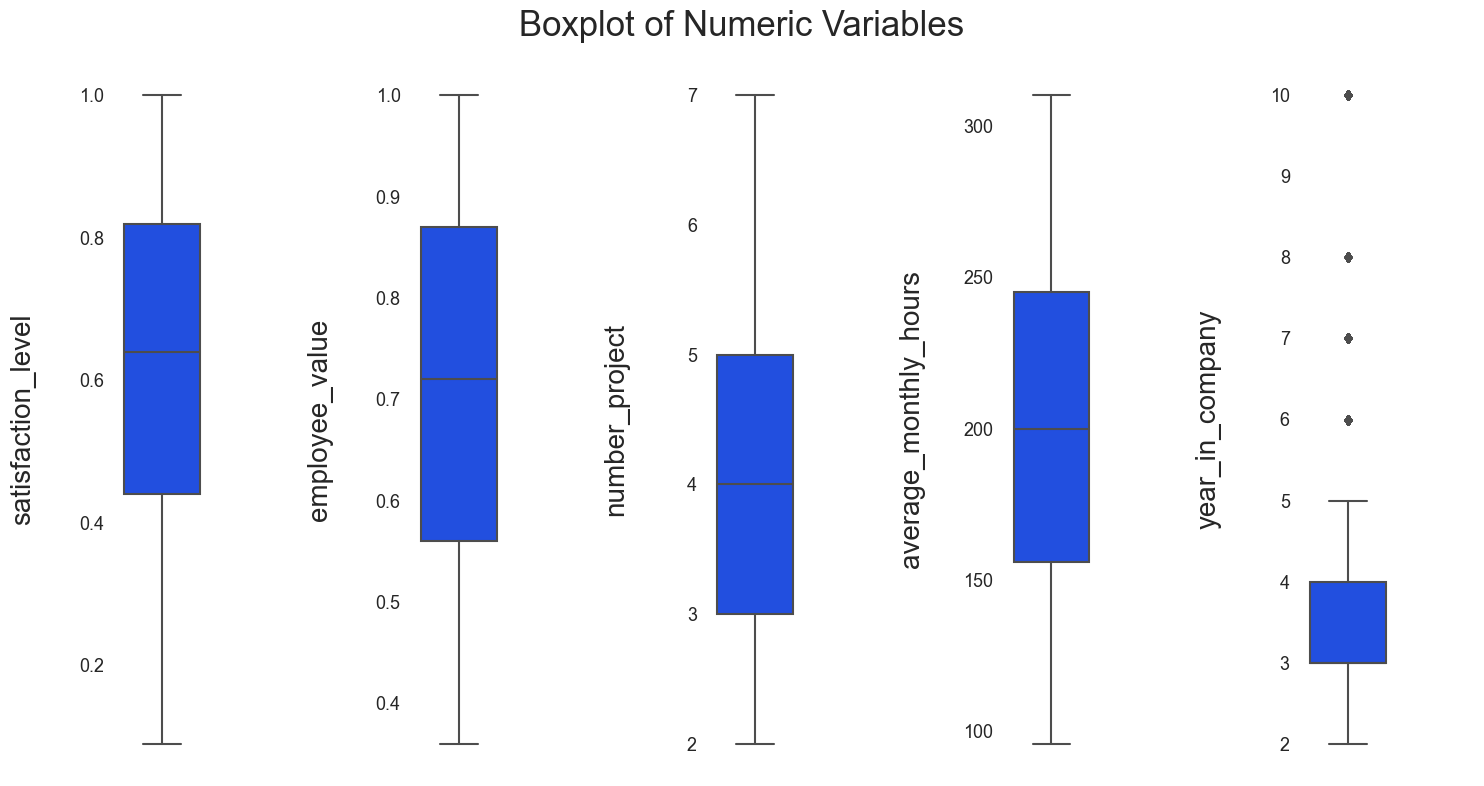

In [1148]:
plt.figure(figsize=(15,8), constrained_layout=True)
plt.suptitle('Boxplot of Numeric Variables', fontsize=25)

cols = df.columns[:5]

for i in range(len(cols)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df[cols[i]], width=0.3)
    adjust_boxplot()

## What is the Distribution of Employee Attrition?

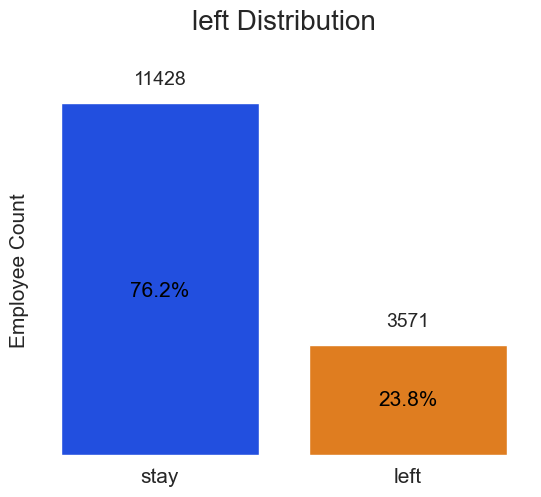

In [1014]:
fig = sns.countplot(x=df['left'])
adjust_barplot(fig, title='left Distribution')

## How Does Satisfaction Level Afeect Attrition Rate?

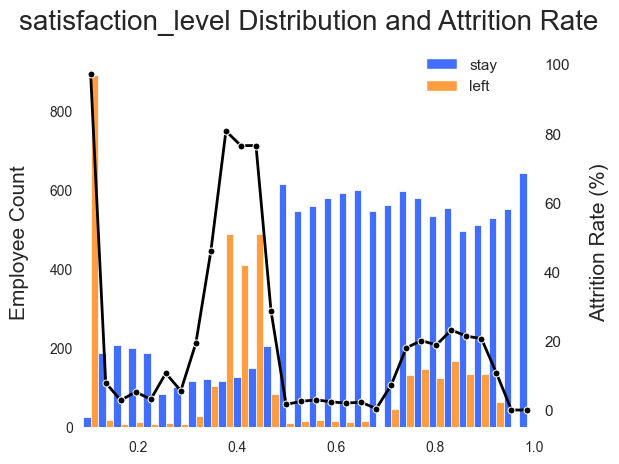

In [1130]:
ax1 = sns.histplot(data=df, x="satisfaction_level", hue='left', multiple='dodge')    
    
adjust_histplot(ax1, title='satisfaction_level Distribution and Attrition Rate')
plot_attrition_rate(ax1)

## How Does Employee Value Affect Attrition Rate?

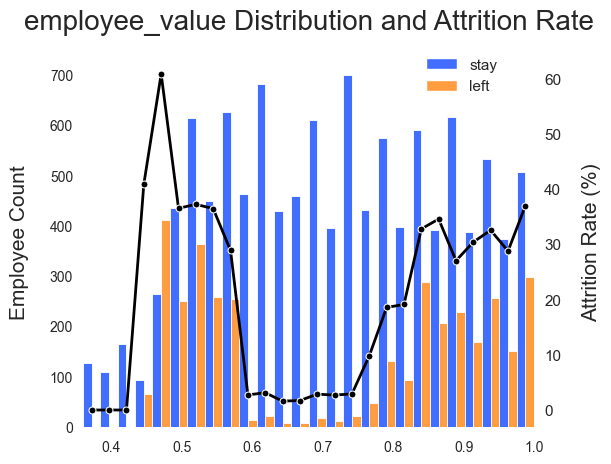

In [1131]:
ax1 = sns.histplot(data=df, x="employee_value", hue='left', multiple='dodge')

adjust_histplot(ax1, title='employee_value Distribution and Attrition Rate')
plot_attrition_rate(ax1)

## How Does Project Numbers Affect Attrition Rate?

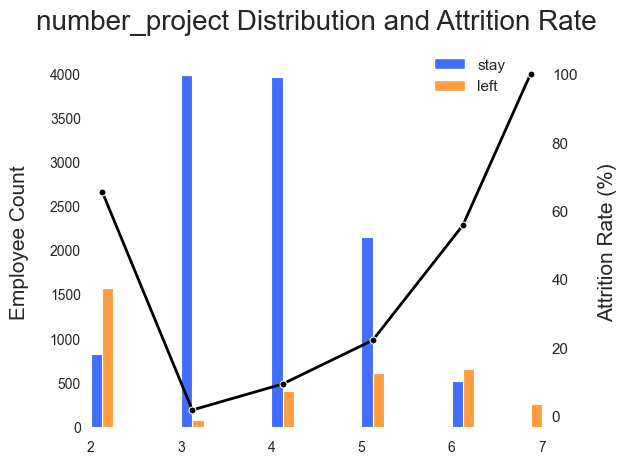

In [1132]:
ax1 = sns.histplot(data=df, x="number_project", hue='left', multiple='dodge', bins=20)

adjust_histplot(ax1, title='number_project Distribution and Attrition Rate')
plot_attrition_rate(ax1)

## How Does Monthly Hours Affect Attrition Rate?

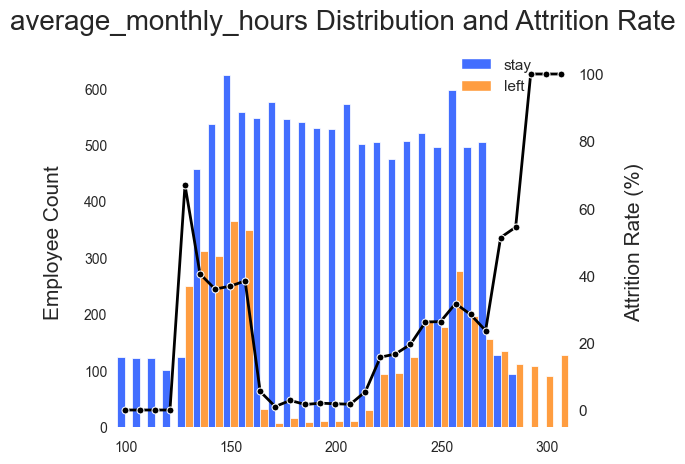

In [1133]:
ax1 = sns.histplot(data=df, x="average_monthly_hours", hue='left', multiple='dodge')

adjust_histplot(ax1, title='average_monthly_hours Distribution and Attrition Rate')
plot_attrition_rate(ax1)

## How Does Seniority Affect Attrition Rate?

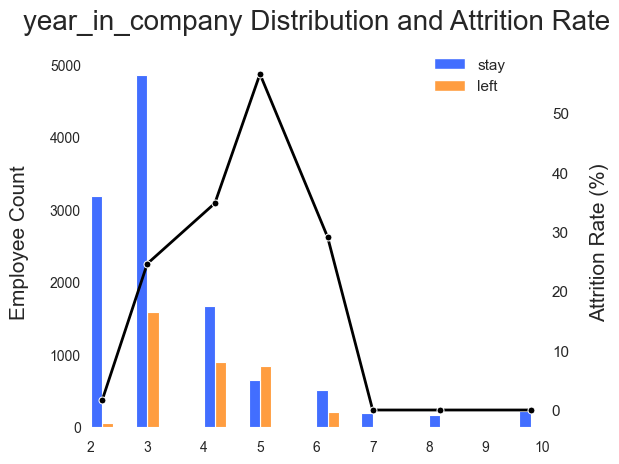

In [1134]:
ax1 = sns.histplot(data=df, x="year_in_company", hue='left', multiple='dodge', bins=20)

adjust_histplot(ax1, title='year_in_company Distribution and Attrition Rate')
plot_attrition_rate(ax1)

## How Does Work Accident Affect Attrition?

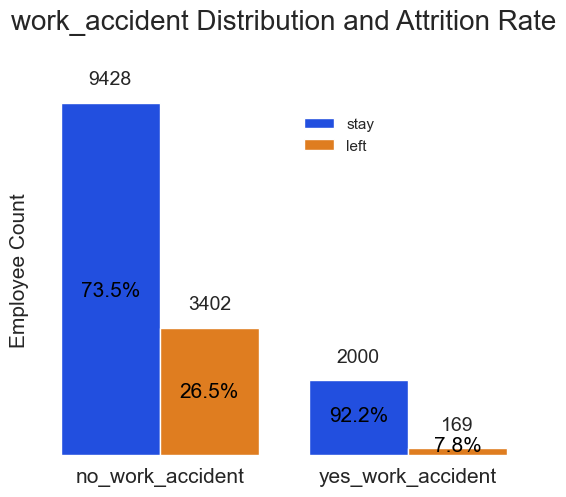

In [1135]:
fig = sns.countplot(data=df, x="work_accident", hue='left')
adjust_barplot(fig, title='work_accident Distribution and Attrition Rate')

## How Does Promotion Affect Attrition?

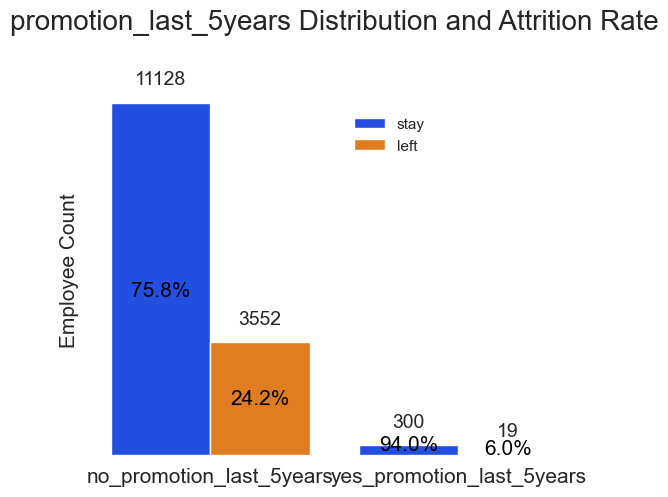

In [1136]:
fig = sns.countplot(data=df, x="promotion_last_5years", hue='left')
adjust_barplot(fig, title='promotion_last_5years Distribution and Attrition Rate')

## How Does Department Affect Attrition?

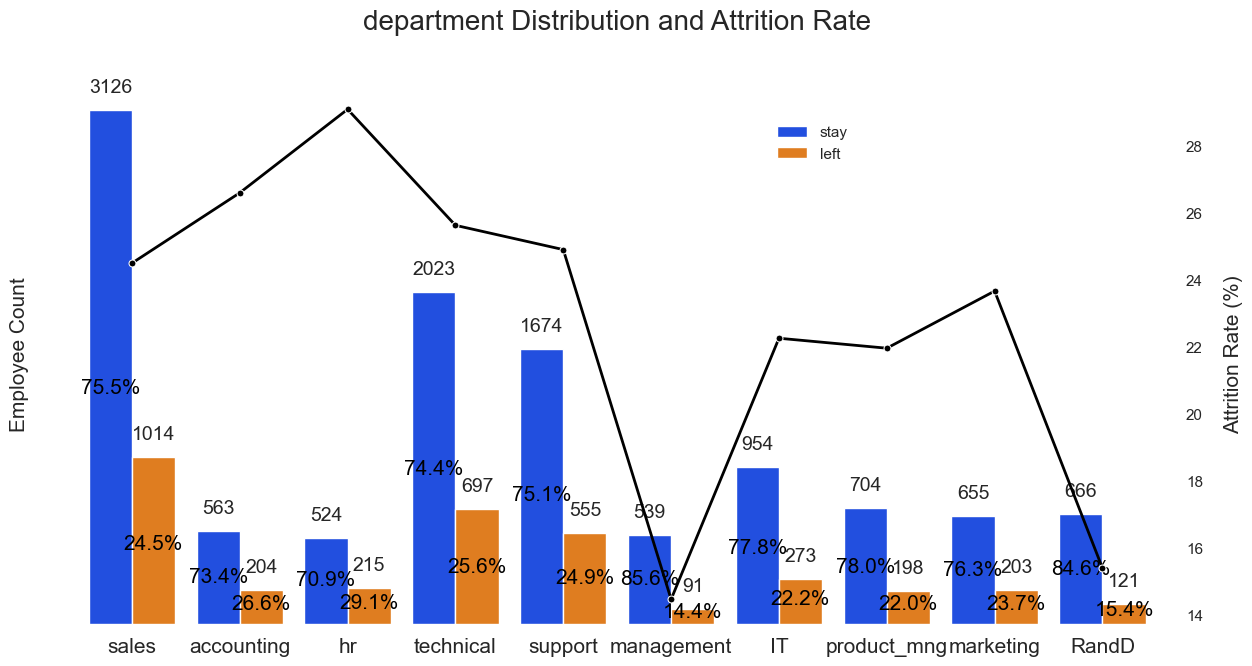

In [7]:
plt.figure(figsize=(15,7))
fig = sns.countplot(data=df, x="department", hue='left')
adjust_barplot(fig, title='department Distribution and Attrition Rate')
plot_attrition_rate(fig)

## How Does Salary Affect Attrition Rate?

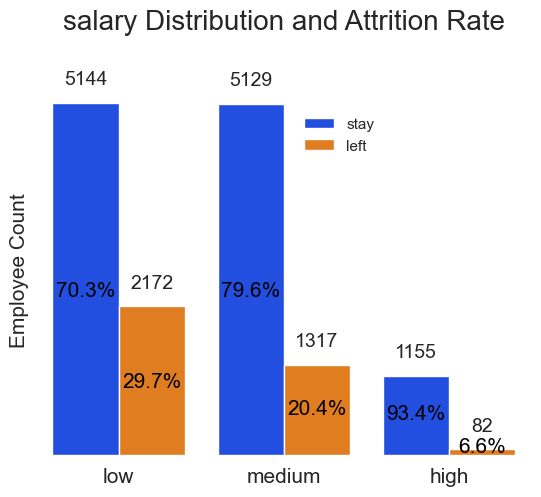

In [1146]:
fig = sns.countplot(data=df, x="salary", hue='left')
adjust_barplot(fig, title='salary Distribution and Attrition Rate')

## Correlation between Variables Using Heatmap

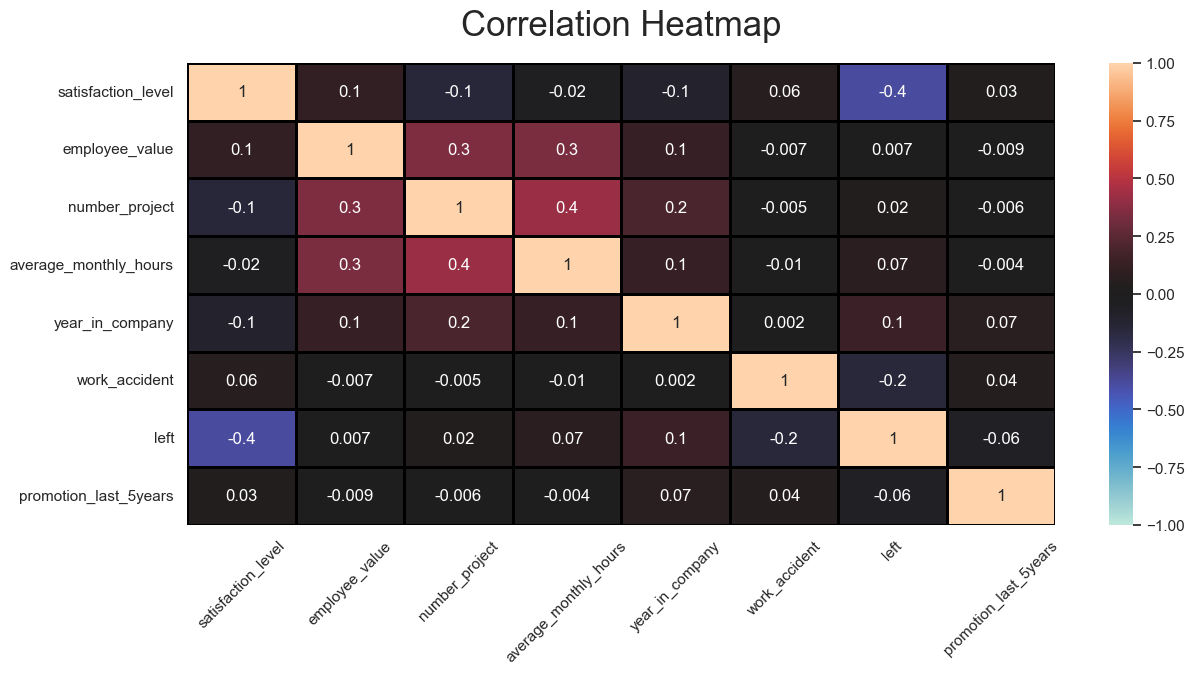

In [1147]:
plt.figure(figsize=(14,6))
heatmap = sns.heatmap(df.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, 
                      linewidths=1, linecolor='Black')
heatmap.set_title('Correlation Heatmap', size=25, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

***

<h1 align='center'> Model Building </h1>

First, split the data into 75% training set and 25% test set. Then, apply standard scaler to numeric variables and encoded categorical variables using one-hot encoding.  Finally, built three models and evaluated them using ROC-AUC score. Three models are:

- Logistic Regression: AUC = 0.812
- Support Vector Classifier: AUC = 0.979
- Random Forest Classifier: AUC = 0.984

## Prepare Data for Model Building

### Train Test Split

In [5]:
X = df.drop(['left'], axis=1)
y = df['left']
X.loc[:, 'work_accident':'salary'] = X.loc[:, 'work_accident':'salary']
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Feature Scaling and One-Hot Encoding
Transfrom the numeric variables using standard scaler, which makes the data less affected by outliers. Encode categorical variables using one-hot encoding.

In [6]:
numeric_col = list(X.columns[:5]) # satisfaction_level, employee_value, number_project, average_monthly_hours, year_in_company
category_col = list(X.columns[-2:]) #  department, salary  
category_bi_col = ['work_accident', 'promotion_last_5years']

full_pipeline = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_col),
    ('category', OneHotEncoder(), category_col)],
    remainder='passthrough'
)

# apply the pipeline to the train and test set
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

##　Model Building

### Logistic Regression

In [20]:
logistic_reg = LogisticRegression(random_state=42)

# tune the model
parameter = {'C': [i/10 for i in range(1, 301)]}
grid_search = GridSearchCV(logistic_reg, parameter, scoring='roc_auc')
grid_search.fit(X_train, y_train)
logistic_reg = grid_search.best_estimator_

# best model parameter on the training set
print('Best Parameter:', grid_search.best_params_)
print('ROC Score (on training set):', grid_search.best_score_)

Best Parameter: {'C': 1.2}
ROC Score (on training set): 0.8236004243744915


### Support Vector Classifier

In [14]:
svm_clf = SVC(random_state=42, probability=True)

# tune the model
parameter = {'C': [i/10 for i in range(1, 301)]}
grid_search = GridSearchCV(svm_clf, parameter, scoring='roc_auc')
grid_search.fit(X_train, y_train)
svm_clf = grid_search.best_estimator_

# best model parameter on the training set
print('Best Parameter:', grid_search.best_params_)
print('ROC Score (on training set):', grid_search.best_score_)

Best Parameter: {'C': 25.9}
ROC Score (on training set): 0.9856877296456196


### Random Forest Classifier

In [21]:
random_forest_clf = RandomForestClassifier(random_state=42)

# tune the model
parameters = {
    'n_estimators': range(1, 300, 10),    
    'max_features': [1, 2, 3, 4, 5]
}
grid_search = GridSearchCV(random_forest_clf, parameters, scoring='roc_auc')
grid_search.fit(X_train, y_train)
random_forest_clf = grid_search.best_estimator_

# best model parameter on the training set
print('Best Parameter:', grid_search.best_params_)
print('ROC Score (on training set):', grid_search.best_score_)

Best Parameter: {'max_features': 4, 'n_estimators': 251}
ROC Score (on training set): 0.9941954482643581


## Test the Model on the Test Set

From the plot, the Random Forest Classifier has a better performance, scoring a 0.984 auc score.

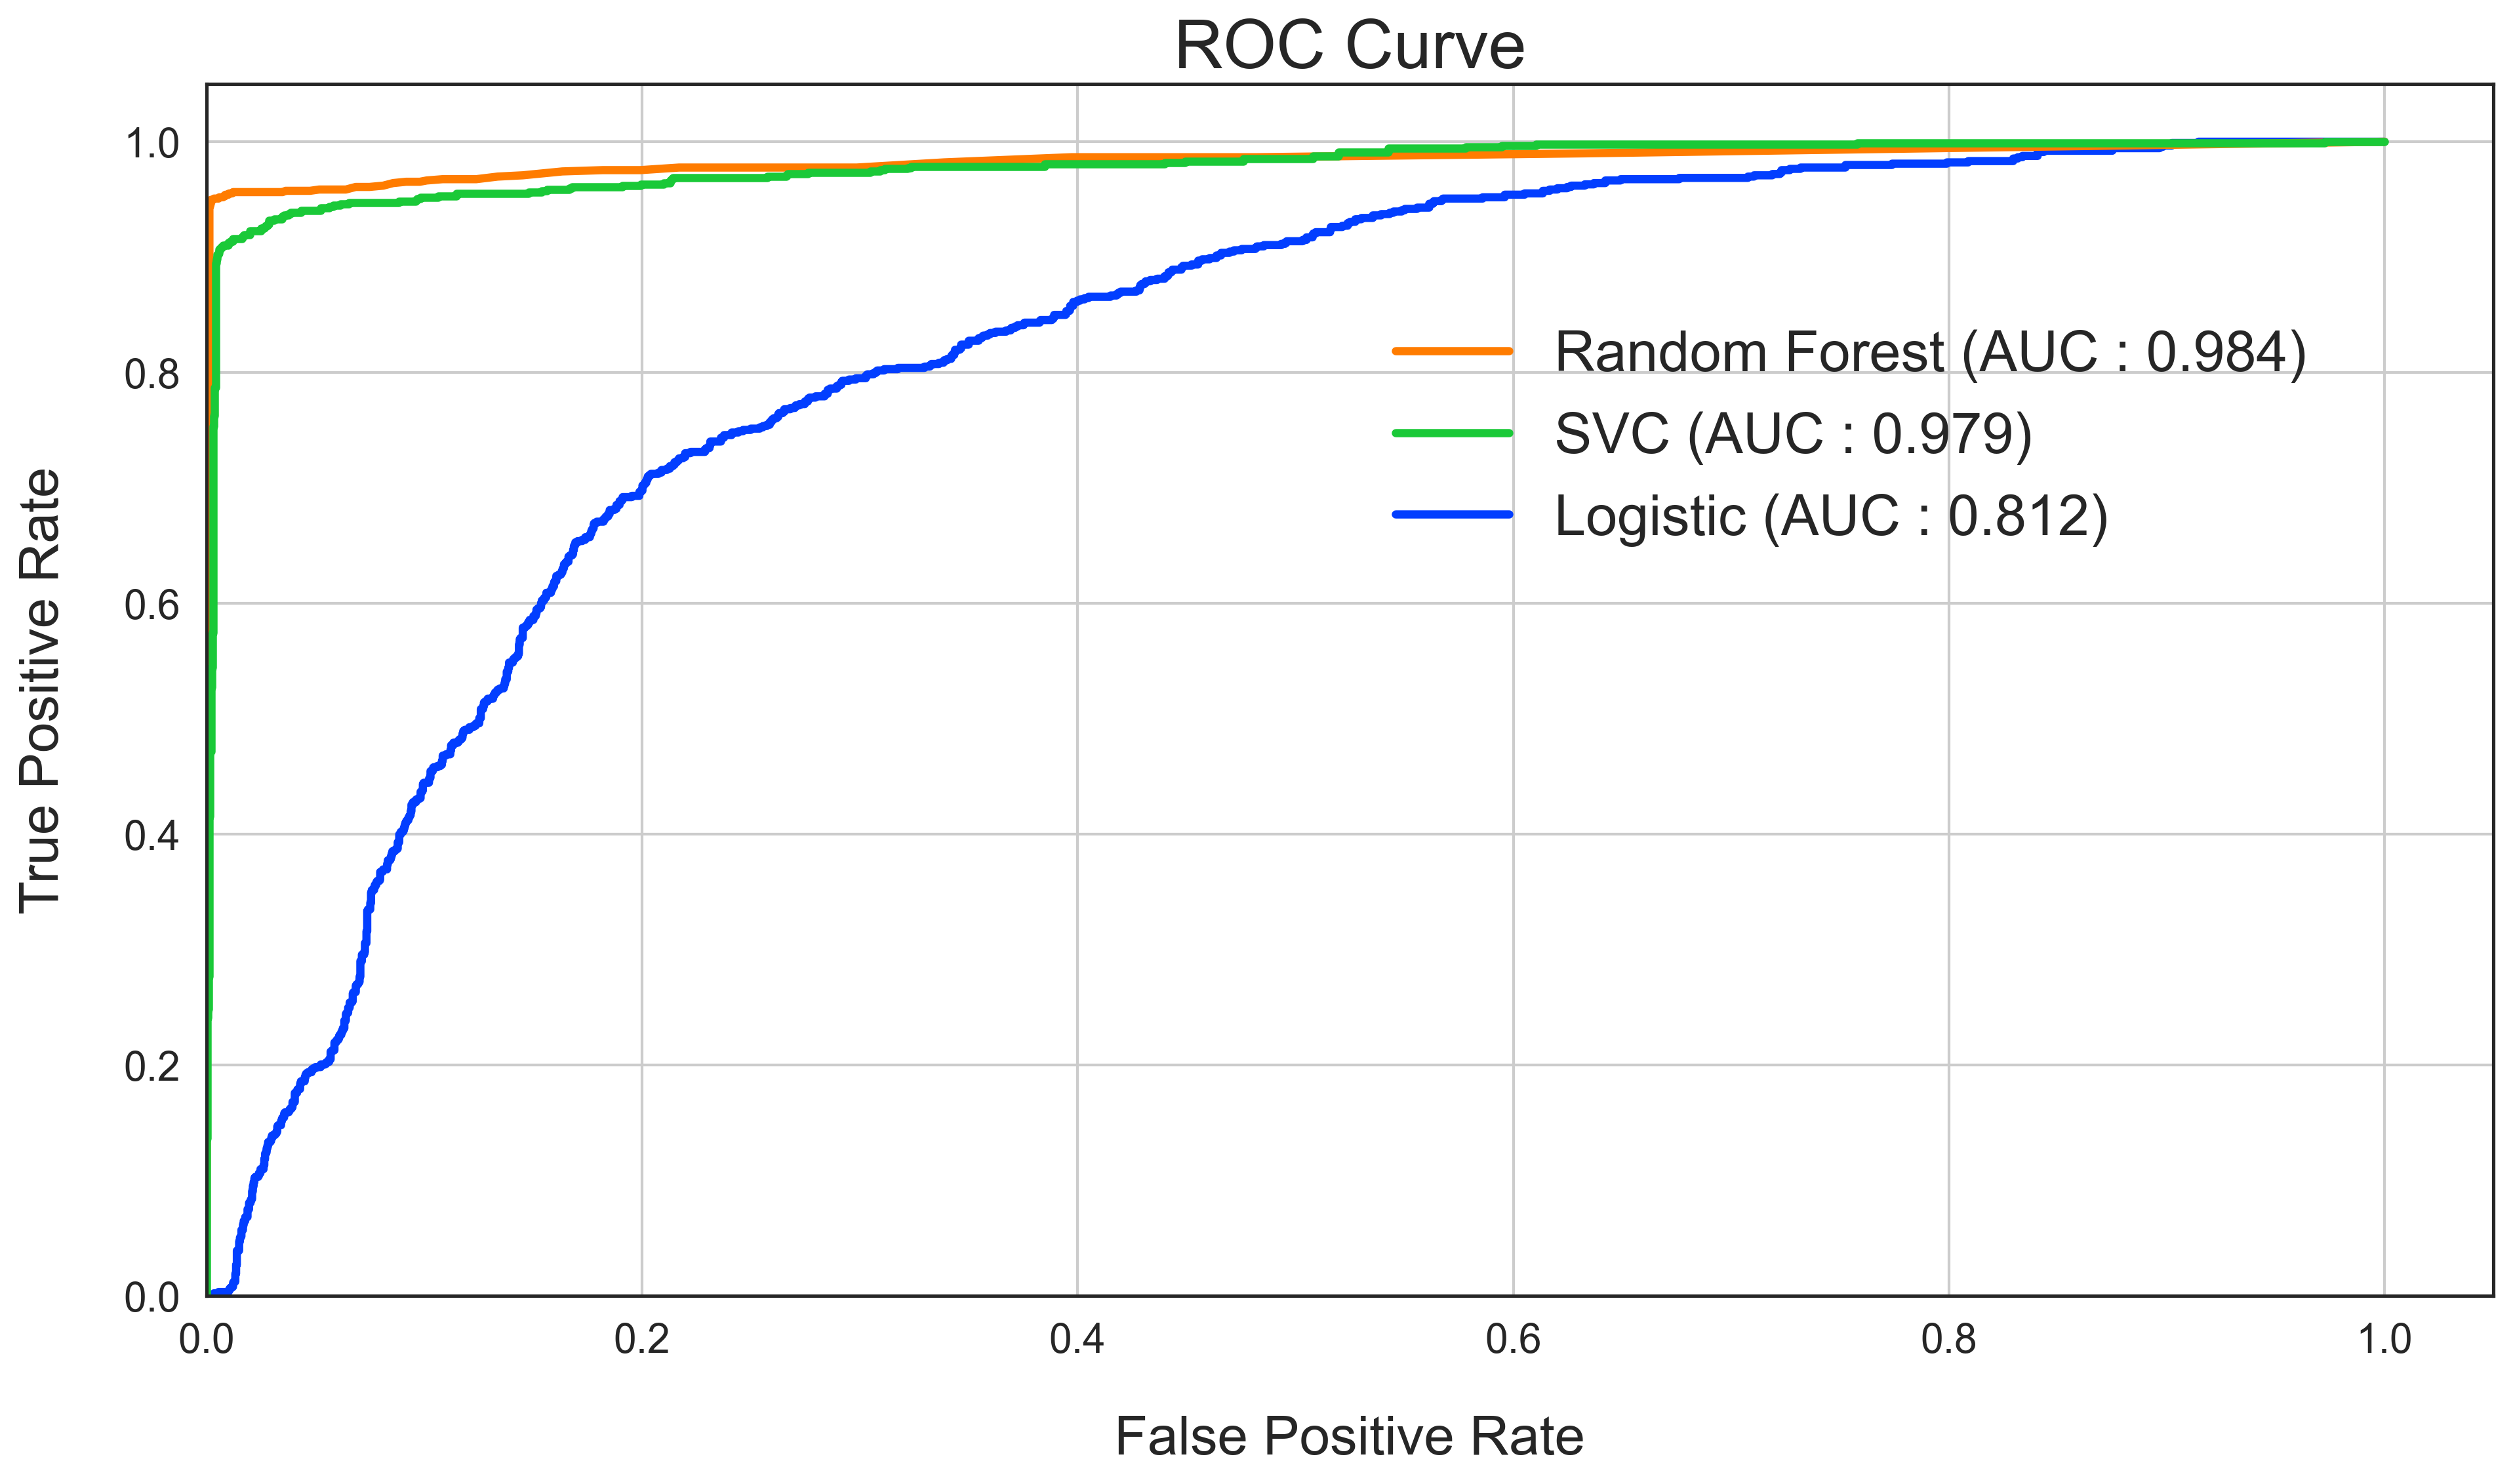

In [39]:
# test the logistic model
y_proba_lr = logistic_reg.predict_proba(X_test)[:, 1]
lr_score = roc_auc_score(y_test, y_proba_lr)

# test the svm model
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
svm_score = roc_auc_score(y_test, y_proba_svm)

# test the random forest model
y_proba_rf = random_forest_clf.predict_proba(X_test)[:, 1]
rf_score = roc_auc_score(y_test, y_proba_rf)

# plot roc curves for two models
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_proba_rf)
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_proba_svm)

plt.figure(figsize=(15,8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic (AUC : {round(lr_score, 3)})', linewidth=3)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC : {round(rf_score, 3)})', linewidth=3)
plt.plot(svm_fpr, svm_tpr, label=f'SVC (AUC : {round(svm_score, 3)})', linewidth=3)

# adjust the plot
plt.title('ROC Curve', size=25)
plt.xlabel('False Positive Rate', size=20, labelpad=20)
plt.ylabel('True Positive Rate', size=20, labelpad=20)
plt.tick_params(labelsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.grid(True)

# adjust the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=(0.51, 0.6), fontsize='xx-large', frameon=False)
plt.show()

## Get Feature Importance

We get the feature importance from the random forest model (all features sum up to 100).

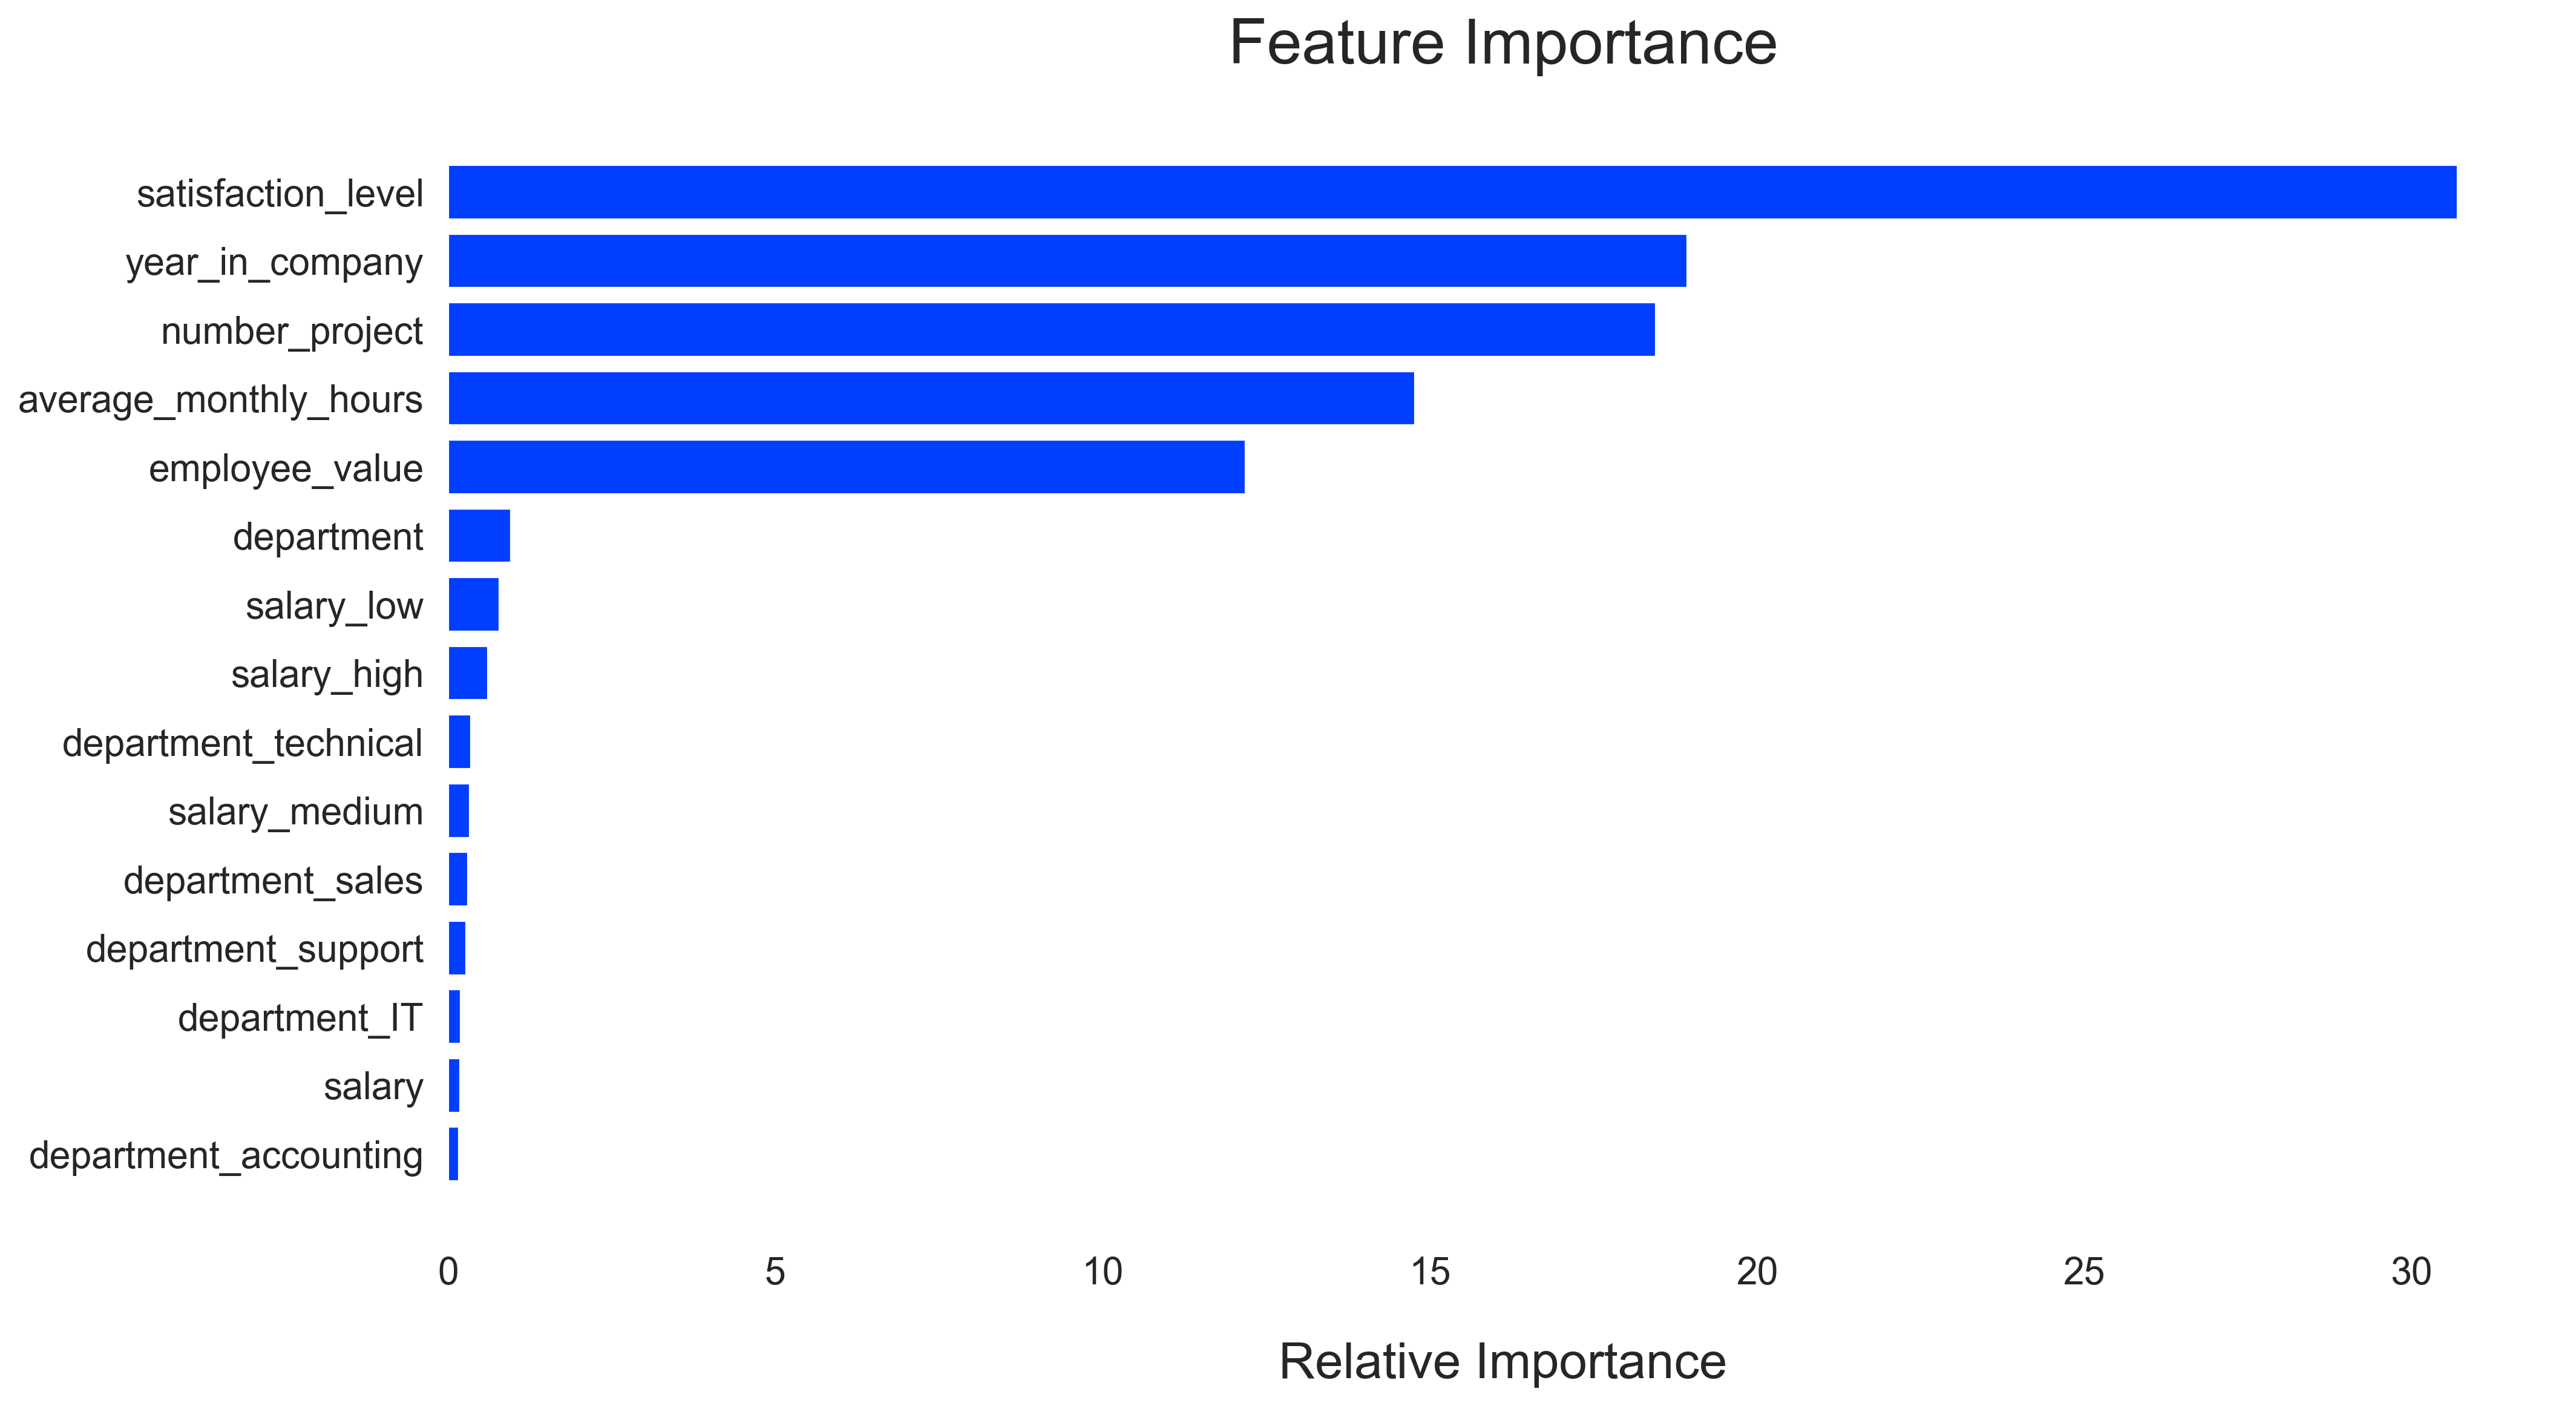

In [31]:
# get all feature names after applying pipeline
category_encoder = full_pipeline.named_transformers_['category']
feature = numeric_col + list(category_encoder.get_feature_names_out()) + category_col

# get feature importance of random classifier model
importance = random_forest_clf.feature_importances_
index = np.argsort(importance)

plt.figure(figsize=(15,8))
plt.box(False)
plt.barh(range(len(index[-15:])), importance[index][-15:]*100, align='center')
plt.yticks(range(len(index[-15:])), [feature[i] for i in index[-15:]])
plt.title('Feature Importance', size=25, pad=20)
plt.xlabel('Relative Importance', size=20, labelpad=20)
plt.tick_params(labelsize=15)
plt.show()